# The ARMA framework, part 1: Simulation and estimation

We will simulate AR(p) and MA(q) processes, which are the building blocks of the ARMA framework, and an ARMA process that combines both together. 

Using the simulated data, we will then illustrate how to:
- use the ACF and PACF as an aid to model selection,
- estimate a specific ARMA model on a given data set,
- after estimating a model, use standard measures and formal tests to evaluate the quality of its fit.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from numpy.random import normal
import math

from matplotlib import pyplot as plt

import wrds
import fredapi

from scipy.optimize import minimize

from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as LjungBox

import os
from dotenv import load_dotenv
load_dotenv();

# Simulations

### AR(p) process:

The first building block of the ARMA framework is the AR(p) process, which is a generalization of the AR(1) process from last week to include any number of lags $p$, instead of just 1. It looks like this:
$$
y_t = \mu + \phi_1 y_{t-1} + ... + \phi_p y_{t-p} + u_t
$$
Here, we will simulate two different AR processes to use later on:

- First, an AR(1) with $\mu=0.01$, $u \sim N(0,1)$, $\phi = 0.8$:
- Second, an AR(3) with $\mu = 0.01$, $u_t \sim \mathcal{N}(0,1)$, and $\phi_1 = \phi_2 = \phi_3 = 0.3$.

The resulting figures are not easy to distinguish. Later on, we will see other ways of looking at the data that will give us a better idea of what process generated them.

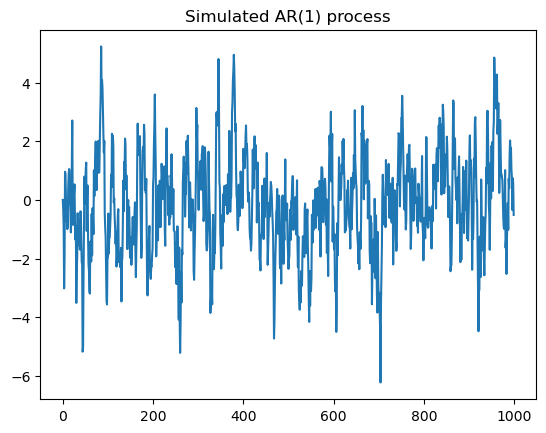

In [2]:
mu = 0.01
phi = 0.8
sigma = 1

N = 1000
AR1 = pd.Series( np.full(N,np.nan) )
AR1[0] = 0
for i in range(1,N):
    AR1[i] = mu + phi*AR1[i-1] + normal(0,sigma)

AR1.plot(title="Simulated AR(1) process");

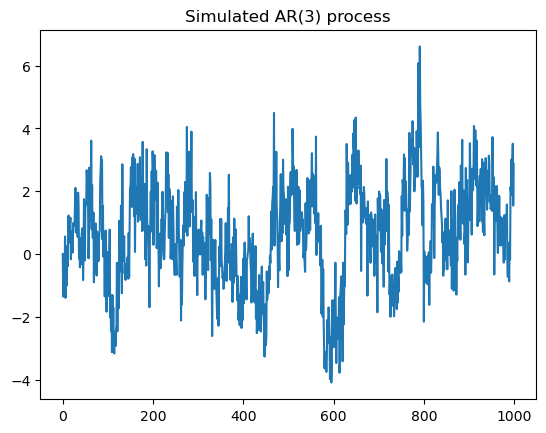

In [3]:
sigma = 1
mu = 0.01
phi1 = 0.3
phi2 = 0.3
phi3 = 0.3

N = 1000

AR3 = pd.Series( np.full(N,np.nan) )
AR3[0] = 0

AR3[1] = mu + phi1*AR3[0] + normal(0,sigma)
AR3[2] = mu + phi1*AR3[1] + phi2*AR3[0] + normal(0,sigma)
for i in range(3,N):
    AR3[i] = mu + phi1*AR3[i-1] + phi2*AR3[i-2] + phi3*AR3[i-3] + normal(0,sigma)

AR3.plot(title="Simulated AR(3) process");

### MA(q) process:

An MA(q) process is given by:
$$
y_t = \mu + u_t + \theta_1 u_{t-1} + ... + \theta_q u_{t-q}
$$
Again, we will simulate two versions of this:

- First an MA(1) with $\mu = 0.01$, $u_t \sim N(0,1)$, $\theta = 1$.
- Second, an MA(3) process with $\mu = 0.01$, $u_t \sim \mathcal{N}(0,1)$, $\theta_1 = 0.9$, $\theta_2 = 0.8$, and $\theta_3 = 0.7$.

An MA process is always stationary. So, we can use any values of $\theta$, and start at any initial value we want, and it will always settle down to a long-run pattern fairly quickly.

Visually, these processes again look very much like the AR1 process. They fluctuates away from their average and then revert back. There is a bit more "spikiness" to an MA process, in the sense that it will move far away from average but then revert back very suddenly, but this is not something we would want to try to judge from the figure. Again, we will see better techniques for this later on.

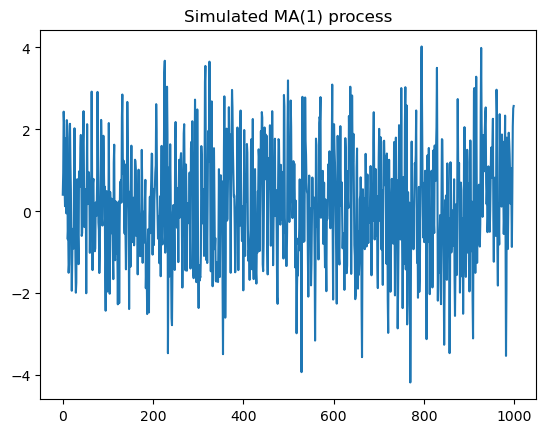

In [4]:
mu = 0.01
sigma = 1
theta = 1

N = 1000

# In simulating the AR processes, we just drew the "shocks" as we calculated each date.
# Here we want to draw the shocks all at once so that we can reuse them as required by the MA formula.
u = normal(0,sigma,N)

MA1 = pd.Series( np.full(N, np.nan) )
MA1[0] = mu + u[0]
for i in range(1,N):
    MA1[i] = mu + u[i] + theta*u[i-1]

MA1.plot(title="Simulated MA(1) process");

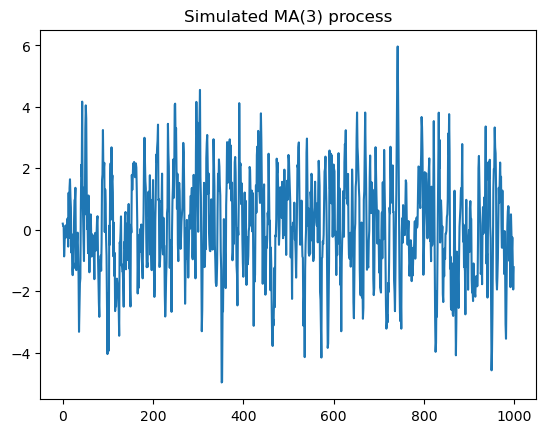

In [5]:
mu = 0.01
sigma = 1
theta1 = 0.9
theta2 = 0.8
theta3 = 0.7

N = 1000

# In simulating the AR processes, we just drew the "shocks" as we calculated each date.
# Here we want to draw the shocks all at once so that we can reuse them as required by the MA formula.
u = normal(0,sigma,N)

MA3 = pd.Series( np.full(N, np.nan) )
MA3[0] = mu + u[0]
MA3[1] = mu + u[1] + theta1*u[0]
MA3[2] = mu + u[2] + theta1*u[1] + theta2*u[0]
for i in range(3,N):
    MA3[i] = mu + u[i] + theta1*u[i-1] + theta2*u[i-2] + theta3*u[i-3]

MA3.plot(title="Simulated MA(3) process");

### ARMA(p,q) process:

An ARMA process is just a combination of AR and MA terms.

For example, an ARMA(1,1) looks like this:
$$
y_t = \mu + \phi y_{t-1} + u_t + \theta u_{t-1}
$$

Here we simulate an ARMA(1,1) process with $\phi = 0.8$, $\theta = 0.8$, and the other parameters as in our earlier simulations.

Once again, the resulting figure itself appears visually not that different from the earlier ones.

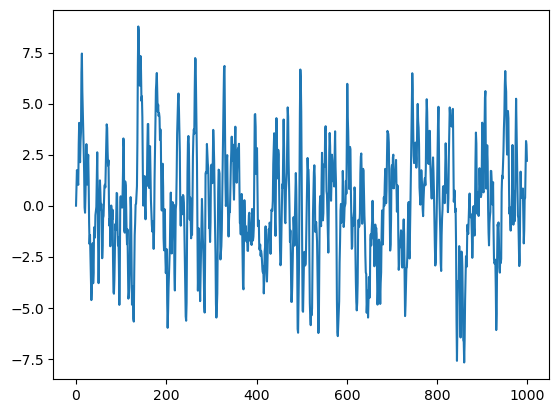

In [6]:
mu = 0.01
phi = 0.8
theta = 0.8
sigma = 1
N = 1000

u = normal(0,sigma,N)

ARMA11 = pd.Series( np.full(N,np.nan) )
ARMA11[0] = 0
for i in range(1,N):
    ARMA11[i] = mu + phi*ARMA11[i-1] + u[i] + theta*u[i-1]

ARMA11.plot();

# ACF and PACF of the simulated series

The autocorrelation function (ACF) plots time on the horizontal axis, and then on the vertical, plots the correlation of the process with its own lag at that amount of time.

The autocorrelation at any lag $h$ is written as $\rho_h$ and defined as $Corr(y_t,y_{t-h}) = \frac{Cov(y_t,y_{t-h})}{Var(y_t)}$. 

- As long as the process is stationary, we will get the same answer for any choice of $t$. All that matters is the size of the lag, $t-h$.
- There are several ways to estimate $\rho_h$ in any given sample. The easiest is to regress $y_t$ directly on 
$y_{t-h}$ and nothing else. The coefficient on $y_{t-h}$ in this regression will match the $h$-order autocorrelation.

The partial autocorrelation function (PACF) is the same, but the vertical axis plots *partial* correlations of $y$ with its own lags. 

- The partial autocorrelation of order $h$ is the correlation of $y_t$ with $y_{t-h}$ while holding fixed all the values of $y$ that come in between those two dates. 
- One way to think about this is as a derivative of $y_t$ with respect to $y_{t-h}$. 
- The easiest way to estimate the PACF is to regress $y_t$ on $y_{t-1}$, $y_{t-2}$, ... $y_{t-h}$, and look at just the final coefficient.

In practice, there are also other methods to calculating the ACF and PACF function, different from the regression approaches described above, and they will give answers that are very slightly different. So you should not be surprised if the approaches above do not perfectly match what comes out of any given software routine. To get perfectly matching results, you would have to carefully investigate the documentation of the software you are using.

**AR(p)**: For this process, the ACF will look like a gently "decaying" pattern, while the PACF will cut off suddenly at $p$, the order of the AR process. We see exactly this pattern for both the AR(1) and AR(3) processes that we simulated.

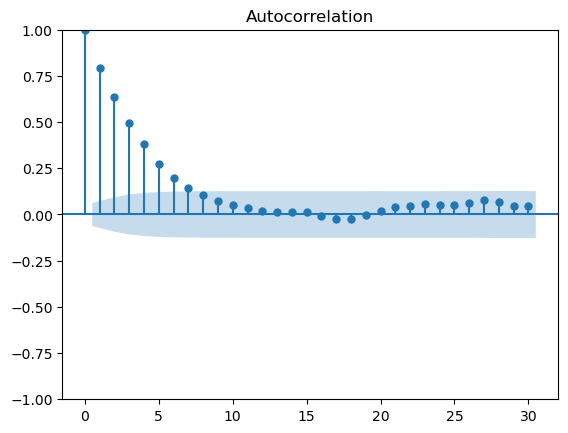

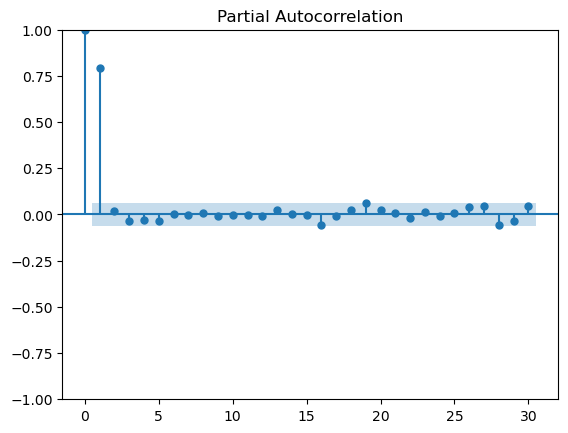

In [7]:
plot_acf(AR1);
plot_pacf(AR1);

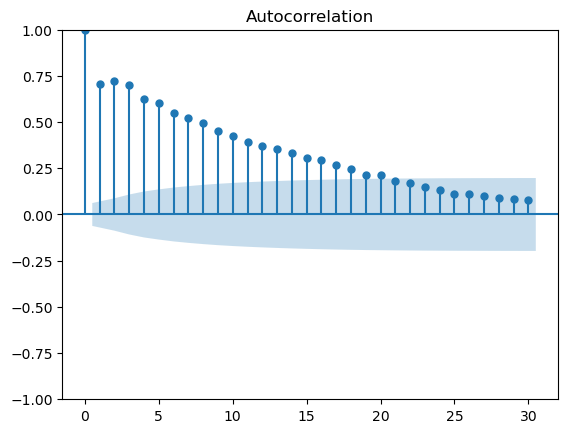

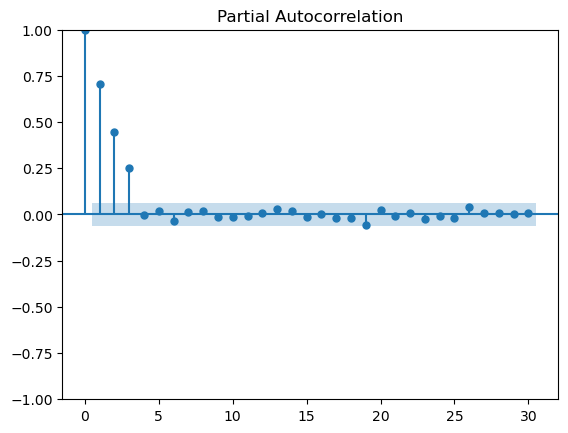

In [8]:
plot_acf(AR3);
plot_pacf(AR3);

<b>MA(q)</b>: For this process, the ACF drops to zero at the order of the MA process, while the PACF displays a characteristic "alternating" pattern.

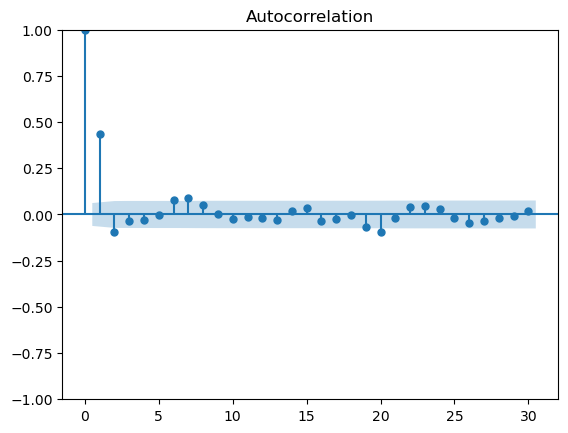

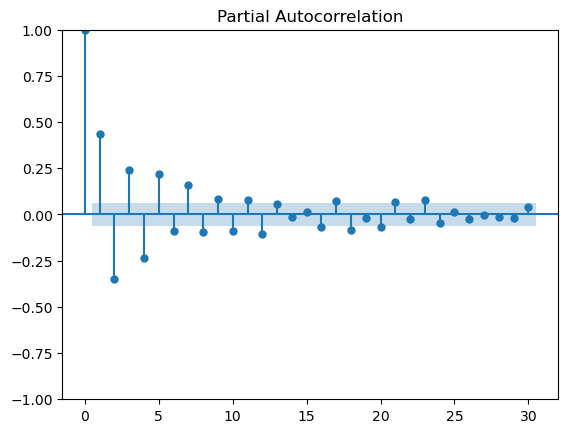

In [9]:
plot_acf(MA1);
plot_pacf(MA1);

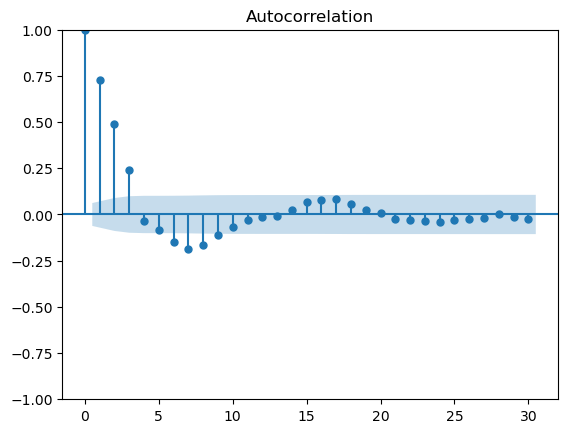

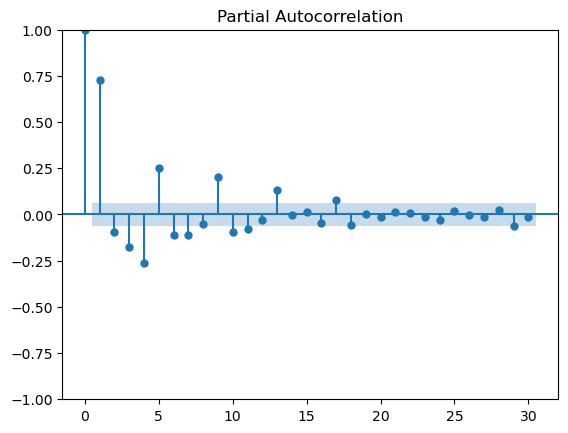

In [10]:
plot_acf(MA3);
plot_pacf(MA3);

**ARMA(p,q)**: The ACF and PACF graphs show the characteristics of both AR and MA processes, which should not be surprising. Here is the ARMA(1,1) data that we simulated: The ACF decays like an AR1, while the PACF alternates like an MA(1).

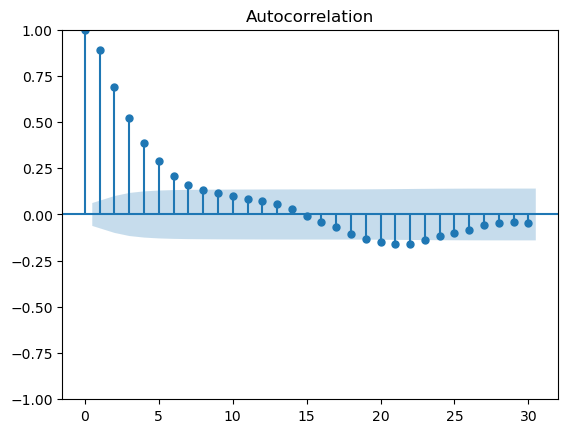

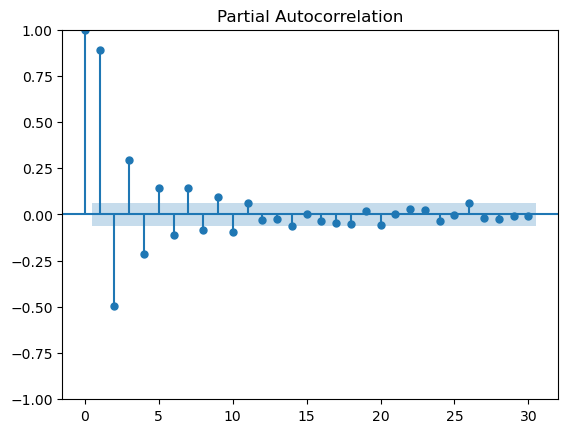

In [11]:
plot_acf(ARMA11);
plot_pacf(ARMA11);

Some simple code to calculate the ACF and PACF directly: 

I will use the simulated ARMA(1,1) process as an example, but this code would work just as well for any of them.

ACF at lag $i$: Just regress $y_t$ on $y_{t-i}$ and report the coefficient.

In [12]:
for i in range(1,6):
    AC = ols("ARMA11 ~ ARMA11.shift(i)",data=ARMA11).fit().params[1]
    print("Autocorrelation at lag " + str(i) + ": " + str(AC) )

Autocorrelation at lag 1: 0.8900241374212293
Autocorrelation at lag 2: 0.6886771191645448
Autocorrelation at lag 3: 0.5213748448213207
Autocorrelation at lag 4: 0.3899190724696392
Autocorrelation at lag 5: 0.2883307201458176


PACF at lag $i$: Regress $y_t$ on *all* of $y_{t-1},...y_{t-i}$, and report only the last coefficient.

In [13]:
for i in range(1,6):
    PAC = ols("ARMA11 ~ " +  " + ".join(["ARMA11.shift("+str(j)+")" for j in range(1,i+1)]),data=ARMA11 ).fit().params[i]
    print("Partial autocorrelation at lag " + str(i) + ": "  + str(PAC) )

Partial autocorrelation at lag 1: 0.8900241374212293
Partial autocorrelation at lag 2: -0.4971629623382176
Partial autocorrelation at lag 3: 0.2959234969728816
Partial autocorrelation at lag 4: -0.21505230821026236
Partial autocorrelation at lag 5: 0.14509041953726437


# Estimation

### AR(p) process: Just run a regression

An AR model can be estimated just by regressing $y_t$ on the appropriate number of its own lags. The examples below do this for the simulated AR1 and AR3 processes. 

Notice that the regression cannot get any of the parameter estimates *exactly* right, but it comes close enough that we cannot statistically reject that it got the right answers.

In [14]:
AR1_ols_results = ols("AR1 ~ AR1.shift()",data=AR1).fit()
print( AR1_ols_results.summary() )

                            OLS Regression Results                            
Dep. Variable:                    AR1   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     1678.
Date:                Thu, 01 Jan 2026   Prob (F-statistic):          6.37e-216
Time:                        14:21:16   Log-Likelihood:                -1435.3
No. Observations:                 999   AIC:                             2875.
Df Residuals:                     997   BIC:                             2884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0294      0.032     -0.910      

In [15]:
AR3_ols_results = ols("AR3 ~ AR3.shift(1) + AR3.shift(2) + AR3.shift(3)",data=AR3).fit()
print( AR3_ols_results.summary() )

                            OLS Regression Results                            
Dep. Variable:                    AR3   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     557.2
Date:                Thu, 01 Jan 2026   Prob (F-statistic):          2.80e-212
Time:                        14:21:16   Log-Likelihood:                -1397.8
No. Observations:                 997   AIC:                             2804.
Df Residuals:                     993   BIC:                             2823.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0806      0.034      2.372   

### MA(q) or ARMA(p,q) process: Maximum likelihood

For a process with MA terms, there is no simple regression you can run to estimate it. We will instead switch to maximum likelihood estimation (MLE). This is not the only possible approach you could use, but it is the most common one. 

To estimate a model by MLE, you could code up the procedure yourself (and we will show an example of this below). But for ARMA models, the estimation can also be done with the ARIMA package in statsmodels, and this is what we will mostly do.

**How to use the ARIMA package:**
Like with the regression package, you use the ARIMA() method to *describe* the model you want to estimate. That command will return a fit() method that you can use to estimate the model, which by default is done with MLE. Finally, that command will return information about the model results, such as params, resid, etc., as well as a summary() method that will print out most of this information.

**How to use the ARIMA() method:**
The first input is the data. The second input is the "order" of the process, which must be three numbers: 

1. The number of AR lags,
2. The level of "integration" - we will talk about this next week. In our current examples it is zero.
3. The number of MA lags.

So an MA1 (our first example below) is described by order=(0,0,1). An ARMA(1,1) is described by order=(1,0,1). And so forth.

**Estimate the MA(1) process by MLE:** Putting it all together, we can estimate an MA(1) process for our simulated MA(1) data as follows,

In [16]:
MA1_MLE_results = ARIMA(MA1,  order=(0,0,1)  ).fit()
print( MA1_MLE_results.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1409.010
Date:                Thu, 01 Jan 2026   AIC                           2824.020
Time:                        14:21:16   BIC                           2838.743
Sample:                             0   HQIC                          2829.616
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1517      0.062      2.429      0.015       0.029       0.274
ma.L1          0.9994      0.018     55.388      0.000       0.964       1.035
sigma2         0.9741      0.049     20.078      0.0

**Match the above output by hand:**
Again, you typically will not want to code up the MLE routine yourself. But let's do an example just to show how it works:

First we create a function that calculates the log likelihood for an MA(1) process.
Remember that this is the probability of observing the data that we actually have, given a set of parameter values for the process (for an MA(1), the parameters are $\mu$, $\sigma$, and $\theta$).
The function itself is something you can look up in many textbooks and papers, and it is also coded into the ARIMA() package. So we are just typing up the same thing by hand here.

In [17]:
def MA1_log_likelihood(params):
    mu,theta,sigma = params
    T = len(MA1)
    eps = np.zeros(T)
    f = np.zeros(T)
    eps[0] = MA1.iloc[0] - mu
    f[0] = 1 + theta**2
    for i in range(1,T):
        eps[i] = MA1.iloc[i] - mu - theta*(eps[i-1]/f[i-1])
        f[i] = 1 + theta**2 - (theta**2) / f[i-1]
    LL = (
        - (T/2)*math.log(2*math.pi)
        - (T/2)*math.log(sigma**2)
        - (1/2)*(np.log(f)).sum()
        - (1/(2*sigma**2))*((eps**2)/f).sum()
    )
    return LL

Next define a helper function that just returns the negative of the log likelihood, since scipy only has a minimizer routine not a maximizer:

In [18]:
def negative_MA1_log_likelihood(params):
    return -MA1_log_likelihood(params)

Then use scipy to minimize that helper function, that is, maximize the likelihood:

In [19]:
MA1_MLE_results_manual = minimize( negative_MA1_log_likelihood, 
                               [ MA1.mean() , 0, MA1.std() ] , 
                               bounds=((None,None),(-1,1),(1e-5,None)) )

And print the parameter estimate matching the ARIMA output above:

In [20]:
mu = MA1_MLE_results_manual.x[0]
print("Estimate of mu: " + '%5.4f' % mu )
theta = MA1_MLE_results_manual.x[1]
print("Estimate of theta: " + '%5.4f' % theta )
sigma2 = MA1_MLE_results_manual.x[2]**2
print("Estimate of sigma^2: " + '%5.4f' % sigma2 )

Estimate of mu: 0.1517
Estimate of theta: 1.0000
Estimate of sigma^2: 0.9736


Finally, for completeness, estimate the MA(3) and ARMA(1,1) model using the ARIMA package:

In [21]:
MA3_MLE_results = ARIMA(MA3, order=(0,0,3)).fit()
print( MA3_MLE_results.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -1416.895
Date:                Thu, 01 Jan 2026   AIC                           2843.789
Time:                        14:21:17   BIC                           2868.328
Sample:                             0   HQIC                          2853.116
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1051      0.106      0.995      0.320      -0.102       0.312
ma.L1          0.8830      0.023     37.792      0.000       0.837       0.929
ma.L2          0.7871      0.026     30.761      0.0

The last set of data was simulated as an ARMA(1,1) model and we saved it with the name ARMA11.
Here we ask the computer to estimate the ARMA(1,1) model on that data, which we know to be the correct model. As expected, the estimated values come close to the true values that we used to simulate the series:

In [22]:
ARMA11_MLE_results = ARIMA( ARMA11, order = (1,0,1) ).fit()
print( ARMA11_MLE_results.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1409.124
Date:                Thu, 01 Jan 2026   AIC                           2826.249
Time:                        14:21:17   BIC                           2845.880
Sample:                             0   HQIC                          2833.710
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0383      0.269      0.142      0.887      -0.489       0.566
ar.L1          0.7859      0.021     37.804      0.000       0.745       0.827
ma.L1          0.8373      0.019     45.036      0.0

# After estimation: Measures of model quality

The summary() command for each estimation already reported the value of the log-likelihood function, the AIC and BIC values, and the results of a Ljung-Box test applied to the residuals. If we need those numbers we can easily access them from the estimation results. For example with the MA1 results:

In [23]:
print("Maximized log-likelihood: " + '%7.3f' % MA1_MLE_results.llf )
print("AIC: " + '%7.3f' % MA1_MLE_results.aic )
print("BIC: " + '%7.3f' % MA1_MLE_results.bic )
LB_results = MA1_MLE_results.test_serial_correlation(method='ljungbox')
print("Ljung-Box test statistic: " + '%5.2f' % LB_results[0,0,0]
       + " (p=" + '%5.2f' % LB_results[0,1,0] + ")")

Maximized log-likelihood: -1409.010
AIC: 2824.020
BIC: 2838.743
Ljung-Box test statistic:  3.79 (p= 0.05)


To illustrate how these are calculated, let's return to the MA1 estimation that we did by hand, and calculate the statistics ourselves:

In [24]:
LL = -MA1_MLE_results_manual.fun
print("Maximized log-likelihood: " + '%7.3f' % LL )
AIC = 2*3 - 2*LL
print("AIC: " + '%7.3f' % AIC )
T = len(MA1)
BIC = math.log(T)*3 - 2*LL
print("BIC: " + '%7.3f' % BIC )
residuals = np.zeros(T)
residuals[0] = MA1.iloc[0]
for i in range(1,T): residuals[i] = MA1.iloc[i] - mu - theta*residuals[i-1]
LB_results = LjungBox(residuals)
print("Ljung-Box test statistic: " + '%5.4f' % LB_results.lb_stat[1]
       + " (p-value: " + '%5.4f' % LB_results.lb_pvalue[1] + ")")

Maximized log-likelihood: -1409.004
AIC: 2824.008
BIC: 2838.731
Ljung-Box test statistic: 4.6743 (p-value: 0.0306)


Visuall, look at the ACF and PACF of the residuals, and hope there are no big patterns:

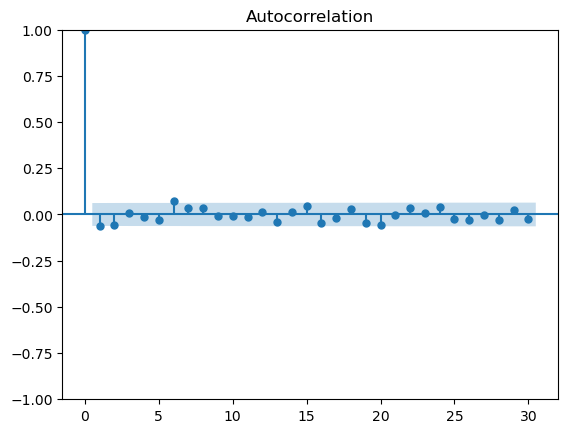

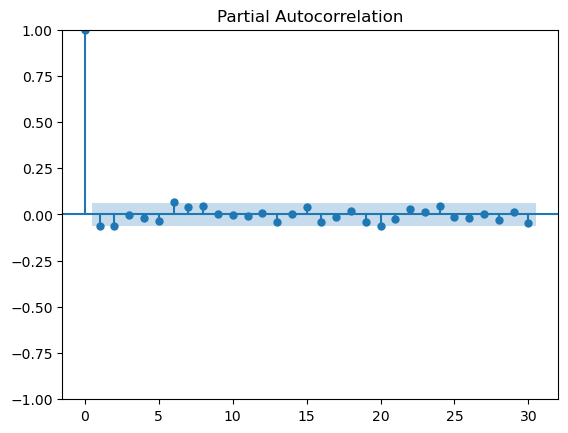

In [25]:
plot_acf(MA1_MLE_results.resid);
plot_pacf(MA1_MLE_results.resid);

## Using these statistics to distinguish between models

Let's return to the simulated ARMA(1,1) data.
We earlier estimated the ARMA(1,1) model on this data, which we knew already was the correct model.
Here again are what the results looked like:

In [26]:
print( ARMA11_MLE_results.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1409.124
Date:                Thu, 01 Jan 2026   AIC                           2826.249
Time:                        14:21:17   BIC                           2845.880
Sample:                             0   HQIC                          2833.710
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0383      0.269      0.142      0.887      -0.489       0.566
ar.L1          0.7859      0.021     37.804      0.000       0.745       0.827
ma.L1          0.8373      0.019     45.036      0.0

And here are the (lack of) time series patterns in the residuals:

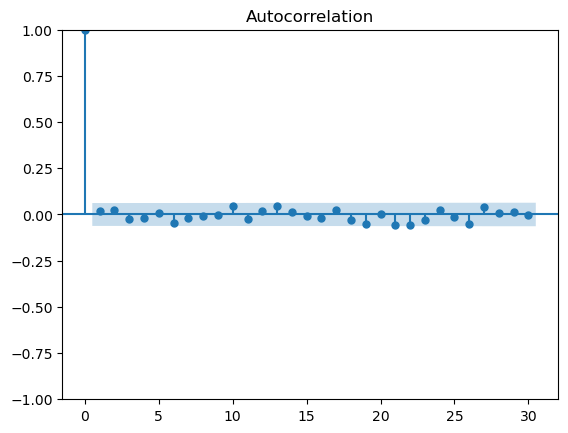

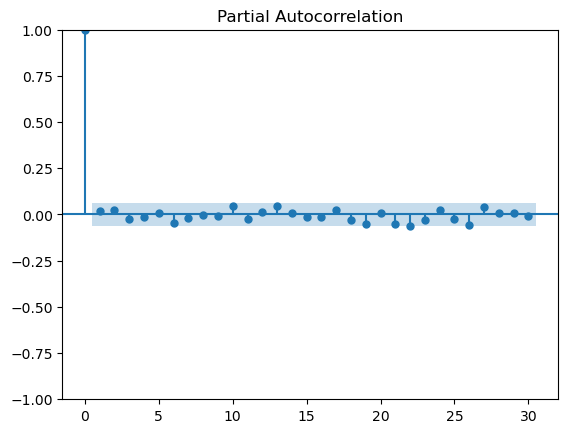

In [27]:
plot_acf(ARMA11_MLE_results.resid);
plot_pacf(ARMA11_MLE_results.resid);

What if we estimated the incorrect model?
For example, suppose we estimated an MA(1) model on this data.

In [28]:
ARMA11_MLE_results_wrong_model = ARIMA( ARMA11, order = (0,0,1) ).fit()
print( ARMA11_MLE_results_wrong_model.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1847.272
Date:                Thu, 01 Jan 2026   AIC                           3700.544
Time:                        14:21:18   BIC                           3715.267
Sample:                             0   HQIC                          3706.140
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0326      0.095      0.344      0.731      -0.153       0.219
ma.L1          0.9578      0.010    100.406      0.000       0.939       0.977
sigma2         2.3494      0.108     21.724      0.0

/home/william/miniforge3/envs/FIN657/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


If we compare with our earlier estimation using the correct model, all the measures of model fit are much worse. We also see that there are still noticeable time series patterns in the residuals:

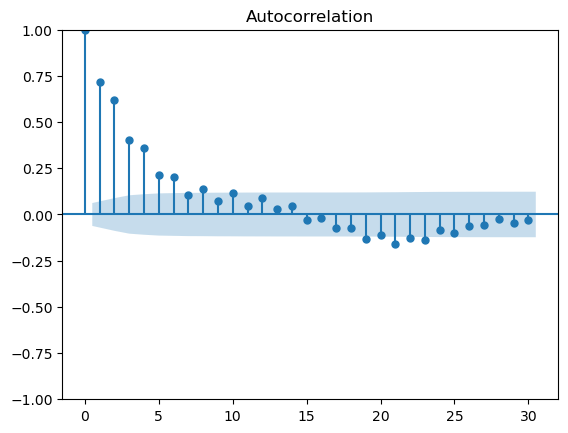

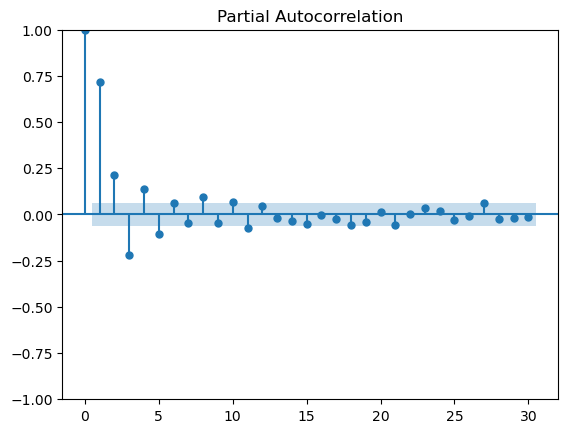

In [29]:
plot_acf(ARMA11_MLE_results_wrong_model.resid);
plot_pacf(ARMA11_MLE_results_wrong_model.resid);

These help us determine that we have not chosen the best model for the data. This process is formalized through the Box-Jenkins "model selection" procedure in the next notebook.